<a href="https://colab.research.google.com/github/juancaalcaraz/practicaML/blob/main/BuenasPracticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Buenas prácticas para la evaluación de modelos y el ajuste de hiperparámetros.
## Pipelines.
### La clase pipelines de scikit-learn nos permite ajustar un modelo incluyendo un número arbitrario de pasos de transformación y aplicarlo para hacer predicciones sobre nuevos datos.
#### En esta ocación usaremos el dataset Breast Cancer Wisconsin.

In [1]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
# leyendo el dataset desde el sitio web de UCI.
# reading the dataset from the UCI website.
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

### Ahora las etiquetas de clase son 0 para un tumor benigno('B') y 1 para un tumor maligno('M'). Para comprobar este mapeo vamos a llamar a le.transform

In [2]:
le.transform(['M','B'])

array([1, 0])

In [3]:
# Dividimos el conjunto de datos en datos de enrenamiento y de prueba.
# We divide the data set into training and test data.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=43)

### Vamos a estandarizar las columnas en el conjunto de datos breast cancer wisconsin antes de pasarlas a un clasificador lineal. Además vamos a suponer que queremos comprimir nuestros datos a partir de las 30 dimensiones iniciales en un subespacio bidimensional mediante un Análisis de componentes principales(ACP). En lugar de hacer estos pasos por separado, podemos encadenar estos objetos en un pipeline:

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
#pipeline para regresion logistica.
#pipeline for logistic regression.
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=43))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test precisión: %.3f' % pipe_lr.score(X_test, y_test))

Test precisión: 0.947


## Validación cruzada para evaluar el rendimiento de un modelo.
### La validación cruzada de k iteraciones es una técnica utilizada para evaluar el rendimiento de un modelo de aprendizaje automático. Consiste en dividir el conjunto de datos en k partes (llamadas pliegues), usar k-1 partes como conjunto de entrenamiento y la parte restante como conjunto de prueba en cada iteración. Esto se repite k veces, de manera que cada parte se utiliza una vez como conjunto de prueba. Al finalizar, se promedian los resultados de las k iteraciones para obtener una estimación más precisa del rendimiento del modelo. La validación cruzada de k iteraciones ayuda a reducir el sesgo en la evaluación del modelo y a obtener una estimación más robusta de su rendimiento.

In [5]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10)
print('CV puntuación de precisión: %s'% scores)

CV puntuación de precisión: [0.97826087 0.91304348 0.95652174 0.93478261 0.89130435 0.95555556
 0.97777778 1.         1.         0.97777778]


In [6]:
import numpy as np
print('Cv precisión: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Cv precisión: 0.959 +/- 0.034


## Diagnosticar problemas de sesgo y varianza con curvas de aprendizaje.
### Vamos a ver cómo podemos utilizar la funcion de curva de aprendizage de scikit-learn para evalual el modeo:

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(solver='liblinear', penalty='l2', random_state=43))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10)

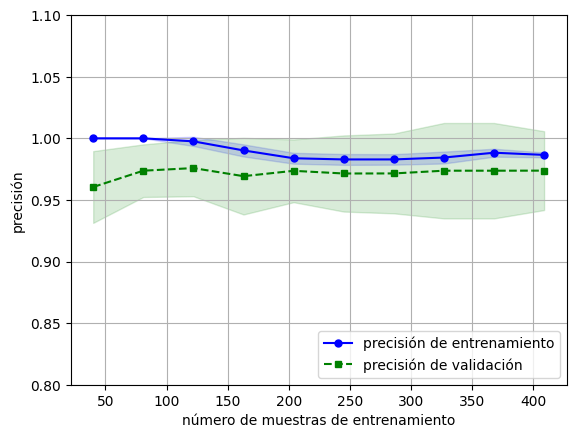

In [8]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o',
         markersize=5, label='precisión de entrenamiento')
#usamos fill_between para graficar la varianza de la estimacion.
#We use fill_between to plot the variance of the estimate.
plt.fill_between(train_sizes, train_mean + train_std,
                 train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--',
         marker='s',
         markersize=5, label='precisión de validación')

plt.fill_between(train_sizes, test_mean + test_std,
                 test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('número de muestras de entrenamiento')
plt.ylabel('precisión')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.1])
plt.show()

### Como podemos ver en la curva de aprendizaje anterior, nuestro modelo funciona bien tanto para muestras de entrenamiento como para los de validacion si ha visto mas de 250 muestras, la precisión de entrenamiento y de validación es más separada para muestras menores a 200, siendo este un indicador de un grado de sobreajuste.   

## Resolver el sobreajuste y el subajuste con curvas de validación.

### Las curvas de validación son una herramienta útil para mejorar el rendimiento de un modelo solventando problemas como el sobreajuste o el subajuste. Con las curvas de validación modificamos los valores de los parámetros del modelo. Vamos a ahcer un ejemplo para el parámetro C de la regresón logística.  

In [9]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] #rango de parámetros.
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train,
                                             y=y_train,
                                             param_name='logisticregression__C',
                                             param_range=param_range,
                                             cv=10)

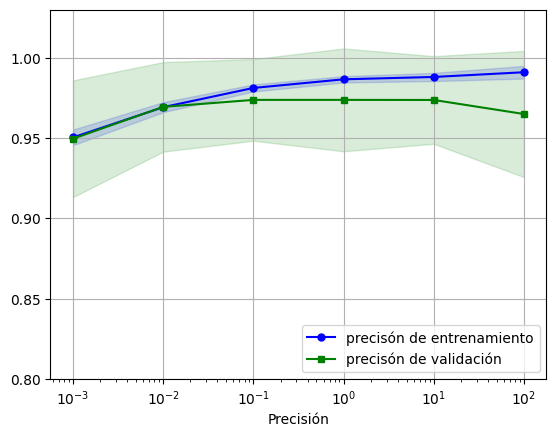

In [10]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean= np.mean(test_scores, axis=1)
test_std= np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o', markersize=5, label='precisón de entrenamiento')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15, color='blue')


plt.plot(param_range, test_mean,
         color='green', marker='s', markersize=5, label='precisón de validación')
plt.fill_between(param_range, test_mean + test_std,
                 test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Precisión')
plt.ylim([0.8, 1.03])
plt.show()

## Ajustar hiperparámetros con búsqueda de cuadriculas.
### El enfoque de búsqueda de cuadrículas es bastante simple; se trata de un paradigma de búsqueda exhaustiva de fuerza bruta donde especificamos una lista de valores para diferentes hiperparámetros y el ordenador evalúa el rendimiento del modelo para cada combinación de dichos valores.

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=43))

param_range = [0.0001,0.001,0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [ {'svc__C':param_range,
               'svc__kernel':['linear']},
              {'svc__C': param_range,
               'svc__gamma':param_range,
               'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator= pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)


0.9781159420289856


In [19]:
print(gs.best_params_)

{'svc__C': 1.0, 'svc__kernel': 'linear'}


In [20]:
#Utilizamos el conjunto de datos de prueba
#para estimar el rendimiento
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('test de precisión: %.3f'% clf.score(X_test, y_test))

test de precisión: 0.982
